# Monte-Carlo Simulations and Statistics
## PyIU Advanced Python Workshop

Last modified: 10/18/2024

Author: Brandon Radzom



This notebook demonstrates the basic ideas behind implementing Monte-Carlo simulations and statistical analyses in Python.

To begin, we import the packages needed for this notebook.

In [ ]:
### general analysis packages
import numpy as np
import scipy as sp
import pandas as pd
# miscellaneous I/O packages
import os
import time
import requests
import warnings
warnings.filterwarnings('ignore')

### plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']=100
%config InlineBackend.figure_format='svg'

### Part 1: Monte-Carlo Methods
#### Introduction

Monte Carlo (MC) methods are experiments involving random, simulated numbers to estimate probability distributions (or functions thereof). Specifically, we create a simulated sample of something from random variable distributions, and use these samples to compute some expected value. These random numbers can be generated by various means.


MC techniques have numerous applications, and are often used to compare methods/modifications of methods. MC can also be used directly for statistical inference, for example, in parametric bootstrap methods and estimating model parameters through the use of Markov-Chain MC simulations.


#### Application in Astronomy
Let's consider an applied example: say that we want to see if planets with **Earth-like masses** ($M\leq 1 M_\oplus$) are ***significantly more water-like*** than planets with **Jupiter-like masses** ($0.3 M_J<M\leq 13 M_J$). To do so, we will compare the **densities** of these two populations. First, we can read in data from NASA's Exoplanet Archive, which contains the masses and radii $R$ for all known exoplanets. Specifically, we put the names of the planets, their masses, and their radii into a `pandas` `DataFrame` called `pscomppars_table`, which is like an Excel Spreadsheet.

In [ ]:
# download the latest pscomppars table from NASA Exoplanet Archive
name = 'pscomppars.csv'
date = time.strftime("%Y-%m-%d", time.localtime()) # get today's date
dated_name = 'pscomppars_'+date+'.csv'
# check if the file exists
if os.path.exists(dated_name):
    print(dated_name+' exists')
else:
    target_url = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+pscomppars&format=csv'
    response = requests.get(target_url)
    data = response.text
    print('downloading '+dated_name)
    with open(dated_name, 'w') as f:
        print(data, file=f)

# date = '2024-10-22'
pscomppars_table = pd.read_csv('pscomppars_'+date+'.csv', comment='#')

pscomppars_2024-10-22.csv exists


In [ ]:
### output the pandas dataframe table of planet data from NASA Exoplanet Archive
pscomppars_table

,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,cb_flag,pl_angsep,pl_angseperr1,pl_angseperr2,pl_angseplim,pl_angsepformat,pl_angsepstr,pl_angsepsymerr,pl_angsep_reflink,pl_ndispec
0,3.12508,OGLE-2016-BLG-1227L b,b,2.104385,OGLE-2016-BLG-1227L,NaN,NaN,NaN,2020-03,2020,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3.14320,Kepler-276 c,c,2.434797,Kepler-276,NaN,NaN,TIC 138213510,2014-02,2013,...,0,0.1740,NaN,NaN,0.0,NaN,0.1740,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
2,3.14880,Kepler-829 b,b,2.494685,Kepler-829,NaN,NaN,TIC 123451768,2016-05,2016,...,0,0.0631,NaN,NaN,0.0,NaN,0.0631,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
3,3.10200,Kepler-477 b,b,2.493252,Kepler-477,NaN,NaN,TIC 158633329,2016-05,2016,...,0,0.2480,NaN,NaN,0.0,NaN,0.2480,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
4,3.12740,TOI-1260 c,c,2.572931,TOI-1260,NaN,NaN,TIC 355867695,2021-08,2021,...,0,0.8930,NaN,NaN,0.0,NaN,0.8930,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,3.13144,TOI-1107 b,b,2.573077,TOI-1107,NaN,NaN,TIC 394561119,2022-05,2022,...,0,0.1990,NaN,NaN,0.0,NaN,0.1990,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
5776,3.19825,KMT-2023-BLG-1642L b,b,2.579416,KMT-2023-BLG-1642L,NaN,NaN,NaN,2024-03,2024,...,0,0.2020,NaN,NaN,0.0,NaN,0.2020,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
5777,3.11331,HD 73267 b,b,2.556950,HD 73267,HD 73267,HIP 42202,TIC 11749208,2009-03,2008,...,0,44.2000,NaN,NaN,0.0,NaN,44.2000,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0
5778,3.19812,OGLE-2017-BLG-1237L b,b,2.579406,OGLE-2017-BLG-1237L,NaN,NaN,NaN,2024-03,2024,...,0,0.4200,NaN,NaN,0.0,NaN,0.4200,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0


Then, we can use these quantities to compute their densities $\rho$ since $\rho=M/V$ and their volumes can be assumed as spherical $V=4/3 \pi R^3$.

In [ ]:
# density function: mass/volume
def density_calc(M, V):
    return M/V
# volume function: scales as radius cubed
def spherical_vol_calc(R):
    return (4/3)*np.pi*R**3


masses = pscomppars_table['pl_bmassj']
radii = pscomppars_table['pl_radj']

# want to calculate density in cgs units (g/cm^3 or gcc)
# start with masses, which needs to be converted from Jupiter masses to grams (g)
# Jupiter mass to grams (g)
def MJ_2_g(m):
    return m*1.899*10**(30)
masses = MJ_2_g(masses)
# now convert radii from Jupiter radii units to cm
def RJ_2_cm(r):
    return r*7.149*10**(9)

radii = RJ_2_cm(radii)

# finally, compute densities
volumes = spherical_vol_calc(radii)
densities = density_calc(masses, volumes)
# and add them back to the dataframe as an extra column called "Densities [gcc]"
pscomppars_table['Densities [gcc]'] = densities

# output the data frame to see our new column of densities
pscomppars_table

,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,pl_angsep,pl_angseperr1,pl_angseperr2,pl_angseplim,pl_angsepformat,pl_angsepstr,pl_angsepsymerr,pl_angsep_reflink,pl_ndispec,Densities [gcc]
0,3.12508,OGLE-2016-BLG-1227L b,b,2.104385,OGLE-2016-BLG-1227L,NaN,NaN,NaN,2020-03,2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.514118
1,3.14320,Kepler-276 c,c,2.434797,Kepler-276,NaN,NaN,TIC 138213510,2014-02,2013,...,0.1740,NaN,NaN,0.0,NaN,0.1740,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,3.71368
2,3.14880,Kepler-829 b,b,2.494685,Kepler-829,NaN,NaN,TIC 123451768,2016-05,2016,...,0.0631,NaN,NaN,0.0,NaN,0.0631,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,2.987768
3,3.10200,Kepler-477 b,b,2.493252,Kepler-477,NaN,NaN,TIC 158633329,2016-05,2016,...,0.2480,NaN,NaN,0.0,NaN,0.2480,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,3.037505
4,3.12740,TOI-1260 c,c,2.572931,TOI-1260,NaN,NaN,TIC 355867695,2021-08,2021,...,0.8930,NaN,NaN,0.0,NaN,0.8930,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,3.461442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,3.13144,TOI-1107 b,b,2.573077,TOI-1107,NaN,NaN,TIC 394561119,2022-05,2022,...,0.1990,NaN,NaN,0.0,NaN,0.1990,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,1.891974
5776,3.19825,KMT-2023-BLG-1642L b,b,2.579416,KMT-2023-BLG-1642L,NaN,NaN,NaN,2024-03,2024,...,0.2020,NaN,NaN,0.0,NaN,0.2020,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,0.720127
5777,3.11331,HD 73267 b,b,2.556950,HD 73267,HD 73267,HIP 42202,TIC 11749208,2009-03,2008,...,44.2000,NaN,NaN,0.0,NaN,44.2000,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,3.305301
5778,3.19812,OGLE-2017-BLG-1237L b,b,2.579406,OGLE-2017-BLG-1237L,NaN,NaN,NaN,2024-03,2024,...,0.4200,NaN,NaN,0.0,NaN,0.4200,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,3.020717


Great, we have densities for each of the 5000+ confirmed exoplanets. Now we need to make some ***data cuts*** to select our two samples: Earths and Jupiters. Here, we employ a simple mass and radius cut, but one may want to employ a number of other quality cuts to get a "cleaner" sample that is more reliable.

In [ ]:
def MJ_2_ME(mass):
    return mass * 317.907
def RJ_2_RE(radius):
    return radius * 11.2089

# create mass and radius ranges for Earths and then cut the data accordingly
mass_cut = ((MJ_2_ME(pscomppars_table['pl_bmassj']) > 0.1) & (MJ_2_ME(pscomppars_table['pl_bmassj']) <= 1))
radius_cut = ((RJ_2_RE(pscomppars_table['pl_radj']) > 0.3) & (RJ_2_RE(pscomppars_table['pl_radj']) <= 1))
earth_table = pscomppars_table[mass_cut | radius_cut]
print('Identified',len(earth_table),'Earth-like planets.')
# create mass and radius ranges for Jupiters and then cut the data accordingly
mass_cut = ((pscomppars_table['pl_bmassj'] > 0.3) & (pscomppars_table['pl_bmassj'] <= 13))
radius_cut = ((RJ_2_RE(pscomppars_table['pl_radj']) > 9) & (RJ_2_RE(pscomppars_table['pl_radj']) < 22))
jupiter_table = pscomppars_table[mass_cut | radius_cut]
print('Identified',len(jupiter_table),'Jupiter-like planets.')

# save their densities to separate variables
earth_densities = earth_table['Densities [gcc]']
jupiter_densities = jupiter_table['Densities [gcc]']

Identified 229 Earth-like planets.
Identified 1762 Jupiter-like planets.


Now we can plot the distribution of densities for both of these planet populations to see if they're visually distinct. Note that we plot them as probability densities, which are normalized, so that they show up on the same y-scale (since there are much fewer Earth-like planets in our sample). We also plot the density of water (1 gcc) for a sense of visual scale.

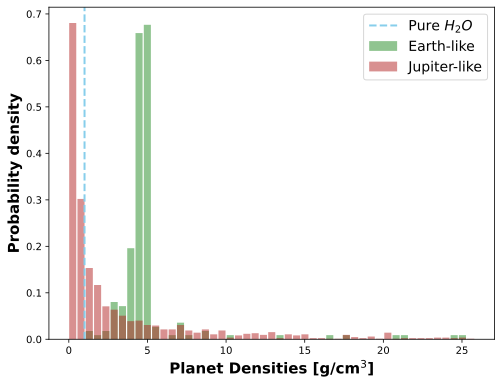

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca()

x_bin = np.linspace(np.min(np.append(earth_densities,jupiter_densities)), np.max(np.append(earth_densities,jupiter_densities)), 50)
y = np.histogram(earth_densities, bins=x_bin, density=True)[0]
ax.bar(x_bin[:-1], y, width=0.45, color='forestgreen', alpha=0.5, label='Earth-like')

y = np.histogram(jupiter_densities, bins=x_bin, density=True)[0]
ax.bar(x_bin[:-1], y, width=0.45, color='firebrick', alpha=0.5, label='Jupiter-like')

ax.set_xlabel('Planet Densities [g/cm$^3$]', fontsize=15, fontweight='bold')
ax.set_ylabel('Probability density', fontsize=15, fontweight='bold')
ax.axvline(1, color='skyblue', linestyle='--', linewidth=2, label='Pure $H_2 O$')
ax.legend(fontsize=14)

Ok, these distributions look pretty different. Indeed, the mean and median densities are *very* different. Due to the extended nature of the distributions, we will utilize their median densities in future analyses.

In [ ]:
mean_earth_dens = np.mean(earth_densities)
median_earth_dens = np.median(earth_densities)

mean_jupiter_dens = np.mean(jupiter_densities)
median_jupiter_dens = np.median(jupiter_densities)

print('Density of water is 1 gcc.')
print('Mean Earth density is',mean_earth_dens,'gcc, while mean Jupiter density is',mean_jupiter_dens,'gcc.')
print('Median Earth density is',median_earth_dens,'gcc, while median Jupiter density is',median_jupiter_dens,'gcc.')

Density of water is 1 gcc.
Mean Earth density is 43.87135472293006 gcc, while mean Jupiter density is 10.178913436987848 gcc.
Median Earth density is 4.863283649340878 gcc, while median Jupiter density is 1.144134750480488 gcc.


We could just take the difference of the planets' median densities and the density of water (1 gcc) to see which populations are more "water-like". But what if we only want to consider a planet to be water-like if its density lies within a specific range, for example, 0.9-1.5 gcc? And what if we want to determine that one population's propensity to be water-like is **statistically significant** compared to the other?

This is where MC methods and statistics come in. This test would be a bit more straightforward to run if the densities are distributed according to Gaussians, as we can use their standard deviations using `numpy.std()` to get a handle on their statistical separation. However, as we can see above, these distributions don't quite match the nice Gaussian shape.

We will run an MC test where we iteratively randomly draw densities and classify planets as either being water-like or not water-like. Specifically, for a fair comparison, we can *randomly* pull the same number of densities from the much larger Jupiter sample ($\sim1700$) that exist in our much smaller Earth-like sample ($\sim200$), and compare the number of water worlds seen in the randomly-drawn Jupiters with that of our Earth sample. We iteratively repeat this process 10,000 times (so we do 10,000 random draws) so that the result is statistically robust. Note that we also ensure we do not repeat draws for the same planetary systems. Let's do it!

In [ ]:
# first compute number of water worlds in Earth sample
NEarth_water = len(earth_densities[(earth_densities >0.9) & (earth_densities <=1.5)])
print('There are',NEarth_water,'/',len(earth_densities) ,'Earths that have water-like densities.')
# now run MC
N = 10000
# initalize array to hold Jupiter water world counts
all_NJupiter_water = np.zeros(N)
for trial in range(N):
    NJupiter_water = 0
    # make sure you don't repeat systems
    i_list = []
    for N_water in range(len(earth_densities)):
        # generate random index
        i = np.random.randint(0, len(jupiter_densities)-1)
        if (i in i_list)==False:
            i_list.append(i)
            rand_density = jupiter_densities[jupiter_densities.index[i]]
            if (rand_density >0.9) & (rand_density <=1.5):
                NJupiter_water += 1
        else: # if draw is repeated
            while (i in i_list): # keep drawing until you get an i that is not repeated
                i = np.random.randint(0, len(jupiter_densities)-1)
            i_list.append(i) # then add to list
            rand_density = jupiter_densities[jupiter_densities.index[i]]
            # check if drawn density is within 0.9-1.5 range
            if (rand_density >0.9) & (rand_density <=1.5):
                NJupiter_water += 1
    all_NJupiter_water[trial] = NJupiter_water


There are 1 / 229 Earths that have water-like densities.


Ok, so we found that only 1/229 Earth-like planets have wate-like densities and are hence 'water worlds'. Then we ran our 10,000 draws of 229 Jupiters each and counted the number of water worlds from each random draw. These counts are stored in an array called `all_NJupiter_water`. Now we can compare the distribution of the number of Jupiter water worlds with the known number of Earth water worlds.

We quantitatively compute the significance of Jupiter-like planets being more water-like than Earth-like planets below. Specifically, we do this by seeing how many standard deviations the median number of water-world Jupiters is away from the number of water-world Earths (1). We can do this because the Jupiter water-world count distribution is Gaussian!

In [ ]:
# import normal distribution from scipy.stats
from scipy.stats import norm

### compute significance of multi result
# first calculate median number of Jupiters that are water worlds
median_NJupiter_water = np.median(all_NJupiter_water)
print('Median number of water-like Jupiters:',median_NJupiter_water)
median_diff = np.abs(median_NJupiter_water - NEarth_water) # calculate deviation from # of Earths that are water
std_dev = np.std(all_NJupiter_water)
print('Standard deviation of Jupiter-like water world counts:',std_dev)
N_sigma = median_diff/std_dev # compute significance as the difference divided by the standard dev
print(median_NJupiter_water)
print('Significance of trend:',N_sigma,'sigma.')

Median number of water-like Jupiters: 29.0
Standard deviation of Jupiter-like water world counts: 4.735841398315615
29.0
Significance of trend: 5.91236015842057 sigma.


We found that Jupiter-like planets are more likely to be water-worlds than Earth-like planets at the level of nearly $6\sigma$ significance. In astronomy, we generally consider results $>3\sigma$ to be significant, so our MC procedure found that this is indeed **statistically significant**! Note, however, that since this result is based on randomly draw numbers, repeated MC experiments may not produce the same results. This is why it is important to run the experiment many times; in this case, $N=10,000$, which helps keep the final significance consistent to within $\sim0.3 \sigma$. Increasing the number of trails (for example, to $100,000$) would give us a more robust result, but at the expense of longer computation time. Likewise, decreasing the number of trials would make our result less reliable.

Let's plot everything out to visualize the result:

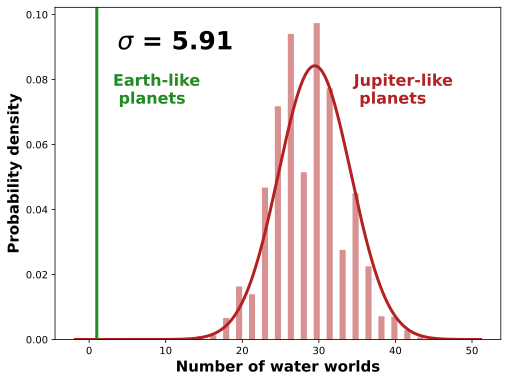

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca()

# plot the distribution of water world counts from the Jupiter population
x_bin = np.linspace(np.min(np.append(NEarth_water,all_NJupiter_water)), np.max(np.append(NEarth_water,all_NJupiter_water)), 30)
y = np.histogram(all_NJupiter_water, bins=x_bin, density=True)[0]
ax.bar(x_bin[:-1], y, width=0.8, color='firebrick', alpha=0.5, label='Earth-like')
# fit the distribution to a Guassian and plot it
mu, std = norm.fit(all_NJupiter_water)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'firebrick', linewidth=3)

ax.set_xlabel('Number of water worlds', fontsize=15, fontweight='bold')
ax.set_ylabel('Probability density', fontsize=15, fontweight='bold')
# add text labels on the plot
ax.text(0.14, 0.93, r'$\sigma$ = '+str(round(N_sigma,2)), transform=ax.transAxes, fontsize=25, fontweight='bold', va='top', ha='left')
ax.text(0.67, 0.7, 'Jupiter-like\n planets', transform=ax.transAxes, fontsize=16, fontweight='bold',  va='bottom', ha='left',  rotation=0, color='firebrick')
ax.text(0.13, 0.7, 'Earth-like\n planets', transform=ax.transAxes, fontsize=16, fontweight='bold', va='bottom', ha='left', color='forestgreen')
ax.axvline(NEarth_water, color='forestgreen', linestyle='solid', linewidth=3)

As seen above, the number of Earth-like water worlds, which is only 1, is far-separated from the distribution of Jupiter-like water worlds, which has a median value of 29. We can see that this separation is $\approx 6$ standard deviations away from the median, to be exact, which means that we can be certain to $\approx 99.99\%$ confidence that Jupiter-like planets are more likely to be water-worlds than Earth-like planets.

This result may not be surprising, but hopefully this example provides a framework for you to use MC techniques for something you're interested in!